In [2]:
import random
import galois
from py_ecc.bls12_381 import curve_order
from pympler import asizeof

from kzg import TrustedEntity, KZGProver, KZGVerifier
from verkle_tree import LeafNode, VerkleTreeNode, VerkleTreeVerifier

In [3]:
GF = galois.GF(curve_order)

# vector commitments

blockchain - miljarda transakcij - nekdo more dokazat, da se je tocno dolocenih 1000 transakcij zgodilo
neki s state connectorjem


In [3]:
SRS_degree = 20
kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)
kzg_verifier = KZGVerifier(GF, curve_order, SRS_degree, kzg_prover.SRS_1, kzg_prover.SRS_2)

arr = [(0, 10), (1, 20), (2, 36), (3, 50), (4, 90), (5, 44), (6, 66)]
print("Array: ", arr)
polynomial = kzg_prover.arr_to_poly(arr)
print("Polynomial: ", polynomial)
commitment = kzg_prover.commit_poly(polynomial)
print("Commitment: ", commitment)

# Batch proof
print("\nBATCH PROOF")
points = [(0, 10), (1, 20), (5, 44)]
proof = kzg_prover.generate_batch_proof(polynomial, points)
print("Batch proof: ", proof)
kzg_verifier.verify_batch_proof(commitment, points, proof)
print("Batch proof is valid")

# One point proof
print("\nONE POINT PROOF")
point = (3, 50)
one_point_proof = kzg_prover.generate_one_point_proof(polynomial, point)
print("One point proof: ", one_point_proof)
kzg_verifier.verify_one_point_proof(commitment, point, one_point_proof, kzg_verifier.SRS_2)
print("One point proof is valid")

Array:  [(0, 10), (1, 20), (2, 36), (3, 50), (4, 90), (5, 44), (6, 66)]
Polynomial:  31024559478616329367006579800676696453966910229478852378373831397463660534171x^6 + 20537384443591091271117031699039503286428799729373324813853099657475944297254x^5 + 6554484396890773809930967563523245729711319062565954727825457337492322648149x^4 + 28402765719860019843034192775267398162082382604452470487243648462466731474701x^3 + 14856831299619087302510193143986023654012323208482830716404369964982598002597x^2 + 3495725011675079365296516033879064389179370166701842521506910579995905412164x + 10
Commitment:  (2765989299817803615111285478215715763429241240501763557551156745652715339849717907538485924162626882026232998680639, 281998715058225488511740687382299198361719397987776155893463371260975717649849648662139630018133723382336917197797)

BATCH PROOF
Batch proof:  (311631458041005400444864211063956378423198290598367972546540641893991894096735407195541829313300643702474100550397, 825524416597814306379349763

# Final additions - probu bom dodat se batching da lahko vec pathou skupi dokazes

path bo dict {0: {0: {set na konc}{}}}

In [4]:
l1 = [10, 20, 31, 40, 51, 60, 70, 80, 90, 100]
l2 = [30, 40, 50, 60, 70, 81, 90, 100, 110, 120]
l3 = [31, 41, 51, 61, 71, 85, 91, 101, 111, 122]
l4 = [35, 42, 56, 4431, 12171, 2385, 9145, 1012, 28111, 232322]
n1 = VerkleTreeNode(curve_order, list(map(LeafNode, l1)), kzg_prover)
n2 = VerkleTreeNode(curve_order, list(map(LeafNode, l2)), kzg_prover)
n3 = VerkleTreeNode(curve_order, list(map(LeafNode, l3)), kzg_prover)
n4 = VerkleTreeNode(curve_order, list(map(LeafNode, l4)), kzg_prover)
root = VerkleTreeNode(curve_order, [n1, n2, n3, n4], kzg_prover)

print("\nVERKLE TREE")
print("Number of elements: ", len(root))
print("Root Commitment: ", root.commitment)
path = {0: [(1, 20), (2, 31), (3, 40)], 1: [(1, 40), (2, 50), (3, 60)]}
print("Path", path)
proof = root.generate_proof(path)
print("Proof", proof)

verifier = VerkleTreeVerifier(root.commitment, kzg_verifier)
verifier.validate_proof(path, proof)
print("Proof is valid")


VERKLE TREE
Number of elements:  40
Root Commitment:  (1611103491431530875736606900897046244905827143670322206780993767342930215015769766744928459258432538846464033663292, 1710862293696573728889876562566646400164943049774849291089462383623154851471581995101939708587965302875158470409636)
Path {0: [(1, 20), (2, 31), (3, 40)], 1: [(1, 40), (2, 50), (3, 60)]}
Proof {-1: Proof(commitment=(1611103491431530875736606900897046244905827143670322206780993767342930215015769766744928459258432538846464033663292, 1710862293696573728889876562566646400164943049774849291089462383623154851471581995101939708587965302875158470409636), proof=(2338084756995274057185224998580648986054422308058692699057003415343425272666843899379084046084867289233019362783768, 1679112747398739263512914973471343925277599134229197099943933174415229001710963602464854245661740789921438213034663)), 0: Proof(commitment=(2907592168109717682332080602572694271657234420097912309645713000732014754748304235323433007824851596203096176465

In [5]:
def build_tree(depth, width, kzg_prover):
    if depth == 1:
        return LeafNode(random.randint(1, curve_order))
    
    t1 = build_tree(depth - 1, width, kzg_prover)
    t2 = build_tree(depth - 1, width, kzg_prover)
    l = [t1 for _ in range(width // 2)] + [t2 for _ in range(width // 2)]
    random.shuffle(l)
    a = VerkleTreeNode(curve_order, l, kzg_prover)
    return a

def build_path(tree):
    if type(tree) == LeafNode:
        return [(0, tree.get_value())]

    if type(tree.children[0]) == LeafNode:
        return [(0, tree.children[0].get_value()), (1, tree.children[1].get_value())]
    
    return {0: build_path(tree.children[0])}

In [10]:
SRS_degree = 30
kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)

# TODO: pump to 6
depth = 4
width = 30
root = build_tree(depth, width, kzg_prover)
path = build_path(root)
print("Path", path)
proof = root.generate_proof(path)
print("Proof", proof)
print("Proof size in bytes: ", asizeof.asizeof(proof))
print("Number of elemtns:", len(root))

length 30
length 30
length 30
length 30
length 30
length 30
length 30
Path {0: {0: [(0, 26997073715901436917329365331571873295004056883934351545243586241515239433621), (1, 26997073715901436917329365331571873295004056883934351545243586241515239433621)]}}
Proof {-1: Proof(commitment=(826306984662543371047938987037501374152614046286971202836440931859491461597175111367917919312961976664516619834267, 2220903191899915032620085087942010545676000404962376822614931684180912428702922225957974206079569135300794286524673), proof=(786064361727680324846360467949329534185181716114857689946457158547746500564716406230600397085910294254438085993473, 414260885068077976403789178613106986440770588611196149945052303889310119476621049197784401795196403778307298543606)), 0: {-1: Proof(commitment=(959821253541275575148280164401783132557598202574741797372227395365967051493597479424933131280217685925558544481589, 1452061789072525721432894344223063108967158179877051154794483995141987543786027234633958620296534785

Depth: 2, Width: 5, Number of elements: 4, Proof size: 1088 bytes
Depth: 3, Width: 5, Number of elements: 16, Proof size: 2408 bytes
Depth: 4, Width: 5, Number of elements: 64, Proof size: 3664 bytes
Depth: 5, Width: 5, Number of elements: 256, Proof size: 4920 bytes
Depth: 6, Width: 5, Number of elements: 1024, Proof size: 6176 bytes
Depth: 2, Width: 10, Number of elements: 10, Proof size: 1088 bytes
Depth: 3, Width: 10, Number of elements: 100, Proof size: 2408 bytes
Depth: 4, Width: 10, Number of elements: 1000, Proof size: 3664 bytes
Depth: 5, Width: 10, Number of elements: 10000, Proof size: 4920 bytes
Depth: 6, Width: 10, Number of elements: 100000, Proof size: 6176 bytes
Depth: 2, Width: 20, Number of elements: 20, Proof size: 1088 bytes
Depth: 3, Width: 20, Number of elements: 400, Proof size: 2408 bytes
Depth: 4, Width: 20, Number of elements: 8000, Proof size: 3664 bytes
Depth: 5, Width: 20, Number of elements: 160000, Proof size: 4920 bytes
Depth: 6, Width: 20, Number of ele

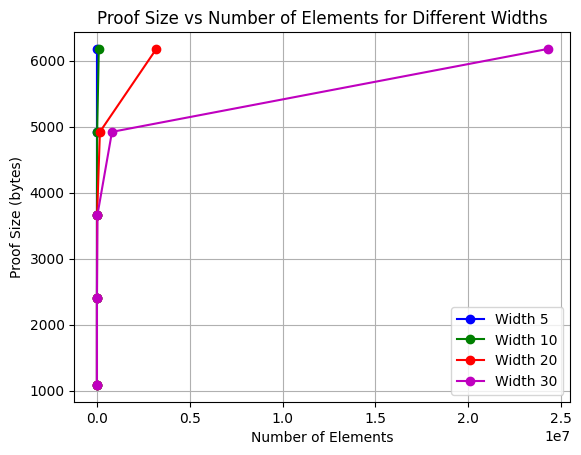

In [8]:
import matplotlib.pyplot as plt

depths = range(2, 7)
widths = [5, 10, 20, 30]
colors = ["b", "g", "r", "m", "y", "k"]

for i, width in enumerate(widths):
    proof_sizes = []
    num_elements = []
    for d in depths:
        SRS_degree = width
        kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
        kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)

        root = build_tree(d, width, kzg_prover)
        path = build_path(root)
        proof = root.generate_proof(path)
        proof_size = asizeof.asizeof(proof)
        proof_sizes.append(proof_size)
        num_elements.append(len(root))
        print(f"Depth: {d}, Width: {width}, Number of elements: {len(root)}, Proof size: {proof_size} bytes")
    
    plt.plot(num_elements, proof_sizes, marker='o', color=colors[i % len(colors)], label=f'Width {width}')

plt.xlabel('Number of Elements')
plt.ylabel('Proof Size (bytes)')
plt.title('Proof Size vs Number of Elements for Different Widths')
plt.legend()
plt.grid(True)
plt.show()